# Default of Credit Card Clients Dataset
Description: This dataset contains 30,000 cases of default payments in Taiwan.

Goal:The goal of this project is to design and implement an Artifical Neural Network to classifiy if a credit card client is credible or not-credible.

# Dataset Information
Number of Instances: 30000

Missing Values: N/A

Attributed Characteristic Types: Integers, Reals

Number of Variables: 23

X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 

X2: Gender (1 = male; 2 = female).

X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

X4: Marital status (1 = married; 2 = single; 3 = others). 

X5: Age (year). 

X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 

X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.

X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

In [1]:
import pandas as pd
import numpy as np

#Read raw data from excel spread sheet
raw_data = pd.read_excel('default of credit card clients.xls')
raw_data.head() #display first 5 rows of data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [2]:
from sklearn.preprocessing import StandardScaler

#Convert the excel spreadsheet data into a numpy array.Note: Ignore the first row which are labels
raw_data_np = raw_data[1:].as_matrix()

#Split up training data and test data(80% = training data, 20% = test data)
#Scale the data using scikit learns StandardScaler
training_data = raw_data_np[:24000, :-1].astype(np.float32) #first 80% of data is for training(set type to float32)
training_data_labels = np.reshape(raw_data_np[:24000, -1], (-1, 1)) #Labels for the training set

scale_data = StandardScaler() #Normalize/center the data
training_data_scaled = scale_data.fit_transform(training_data) 

testing_data = raw_data_np[24000:, :-1].astype(np.float32) #20% of the data is for testing(set type to float32)
testing_data_labels = np.reshape(raw_data_np[24000:, -1], (-1, 1))
testing_data_scaled = scale_data.transform(testing_data) #Normailze/center the data



# Overview of Deep Neural Network Model

The Deep Neural Network Model implemented in this project is a binary classifier.The Architecture of the DNN consist of an input layer(pass-through layer), 4 hidden layers, and an output layer. The size of the input layer is 23, which is the number of features to given. The 4 hidden layers gradually decrease in number of neurons. In each hidden layer, the ELU activation function is used.The output layer has a single output, which is a probability in the range [0, 1] produced from the a sigmoid logistic regression function.

For normalization of each layer's inputs, Batch Normalization is used. 

Mini-batch Gradient Descent is used to train the model with the help of backpropagation. The Logistic Cost Function is used to measure the cost and compute the gradients needed for training.

# Batch Normalization

Mean of batch: $\mu _{b}=\frac{1}{m_{b}}\sum_{i=1}^{m_{b}}x^{(i)}$

Standard Deviation of Batch: $\sigma_{b}^2=\frac{1}{m_{b}}\sum_{i=1}^{m_{b}}(x^{(i)}-\mu_{b})^2$

Normalization: ${\hat{x}^{(i)}}=\frac{x^{(i)}-\mu_{b}}{\sqrt{\sigma_{b}^2 + \varepsilon }}$

Scale and shift: $z^{(i)}=y\hat{x}^{(i)}+b$

In [11]:
import tensorflow as tf

tf.reset_default_graph()
num_inputs = 23
num_hidden_1 = 23 #Number of neurons in 1st hidden layer
num_hidden_2 = 20 #Number of neurons in 2nd hidden layer 
num_hidden_3 = 15 #Number of neurons in 3rd hidden layer
num_hidden_4 = 10 #Number of neurons in 4th hidden layer
num_outputs = 1    

#define place holders for input data to be used for mini-batch
X = tf.placeholder(tf.float32, shape=(None, num_inputs), name="X") #Input data
y = tf.placeholder(tf.int32, shape=(None, num_outputs), name="y") #Output(target) data

#A placeholder to tell batch normalization whether to compute mean and standard deviation off of mini-batches or
#entire set of training data.
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn_model"):
    #Hidden layer 1
    hidden_1 = tf.layers.dense(X, num_hidden_1, activation=None, name="hidden_1") 
    bn_1 = tf.layers.batch_normalization(hidden_1, training=training, momentum=0.99) #batch normalization
    bn_1_activation = tf.nn.relu(bn_1) #ELU activation function
    
    #Hidden layer 2
    hidden_2 = tf.layers.dense(bn_1_activation, num_hidden_2, activation=None, name="hidden_2") 
    bn_2 = tf.layers.batch_normalization(hidden_2, training=training, momentum=0.99) #batch normalization
    bn_2_activation = tf.nn.relu(bn_2) #ELU activation function
    
    #Hidden layer 3
    hidden_3 = tf.layers.dense(bn_2_activation, num_hidden_3, activation=None, name="hidden_3") 
    bn_3 = tf.layers.batch_normalization(hidden_3, training=training, momentum=0.99) #batch normalization
    bn_3_activation = tf.nn.relu(bn_3) #ELU activation function
    
    #Hidden layer 4
    hidden_4 = tf.layers.dense(bn_3_activation, num_hidden_4, activation=None, name="hidden_4") 
    bn_4 = tf.layers.batch_normalization(hidden_4, training=training, momentum=0.99) #batch normalization
    bn_4_activation = tf.nn.relu(bn_4) #ELU activation function
    
    #Output layer
    #For the activation of the last layer, a sigmoid function is used to output a probability between 0 and 1
    output = tf.layers.dense(bn_4_activation, num_outputs, name="output")
    bn_output_logits = tf.layers.batch_normalization(output, training=training, momentum=0.99)
    
    

In [12]:
#If the probability outputted is > 0.5(50%), then the prediction is True(=1)...else it is False(=0)
probability_thresh = tf.constant(0.5, dtype=tf.float32, name="logistic_probability_thresh")

with tf.name_scope("model_loss"):
    #Sigmoid Logistic Regression Function
    probabilities = tf.nn.sigmoid(bn_output_logits, name="sigmoid_activation")
    
    #Logistic regression model prediction
    log_reg_pred = probabilities >= probability_thresh
    
    #Cost function
    loss = tf.losses.log_loss(labels=y, predictions=probabilities)
     

In [13]:
learning_rate = 0.01
with tf.name_scope("train"):
    #Use gradient descent to reduce loss
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    #computes gradients and applys gradients
    training_op = optimizer.minimize(loss)
    


In [14]:
with tf.name_scope("eval"):
    #Calculate accuracy of values correctly classified
    correct = tf.equal((tf.cast(y, tf.int32)), tf.cast(log_reg_pred,tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    

In [15]:
#Helper function to retreive mini-batchs
def get_mini_batch(X, y, current_batch_num, batch_numbers):
    '''
    Get mini-batch of input data and labels. Each dataset will be split in n number of batches, and 
    current batch number will select the necessary mini-batch from the subsets of the split.
    
    Parameters:
        X: Input dataset to be fed for training into the DNN
        y: The target dataset for the input data used to train the DNN on
        current_batch_num: The current iteration in training to select a new mini-batch.
        batch_numbers: The overall number of batchs to split the whole dataset into
    
    Returns:
        batch_X: The mini-batch for input training data
        batch_y: The mini-batch for target training data
    '''
    X, y= np.asarray(X), np.asarray(y)
    batch_X = np.split(X, batch_numbers)[current_batch_num]
    batch_y = np.split(y, batch_numbers)[current_batch_num]
    return batch_X, batch_y


In [17]:
n_epochs = 40 #Number of epochs
batch_size = 100 #Batch size

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) #extra operations to be computed during training for batch normalization
init = tf.global_variables_initializer() #Node to initialize all variables
batch_numbers = int(training_data_scaled.shape[0] / batch_size) #Number of batchs to train on whole data set

#loss data list to plot
log_loss_plot = []

with tf.Session() as sess:
    init.run() #Initialize global variables for the session
    
    for epoch in range(n_epochs):
        for iteration in range(batch_numbers):
            
            #Get the current mini batch for the given iteration to compute gradients
            X_batch, y_batch = get_mini_batch(training_data_scaled, training_data_labels, iteration, batch_numbers)
            
            #Train the model on current mini batch
            sess.run([training_op, extra_update_ops], feed_dict={training:True, X:X_batch, y:y_batch})
            
            #Every 10 iterations, save the Logarithmic Loss to be plotted on the cost function graph
            if(iteration % 10 == 0):
                log_loss_plot.append(loss.eval(feed_dict={X:training_data_scaled, y:training_data_labels}))
        
        #Calculate the current accuracy at epoch n after each training step over the whole training set
        accuracy_val = accuracy.eval(feed_dict={X:testing_data_scaled, y:testing_data_labels})
        
        #Compute the loss of the training set
        log_loss = loss.eval(feed_dict={X:training_data_scaled, y:training_data_labels})
        print("Epoch:", epoch)
        print("|Testing Accuracy:", accuracy_val, "|")
        print("|Training Log Loss:", log_loss, "|")
        


Epoch: 0
|Testing Accuracy: 0.80483335 |
|Training Log Loss: 0.5371692 |
Epoch: 1
|Testing Accuracy: 0.8156667 |
|Training Log Loss: 0.49723056 |
Epoch: 2
|Testing Accuracy: 0.817 |
|Training Log Loss: 0.47866413 |
Epoch: 3
|Testing Accuracy: 0.82016665 |
|Training Log Loss: 0.46989128 |
Epoch: 4
|Testing Accuracy: 0.82133335 |
|Training Log Loss: 0.4651575 |
Epoch: 5
|Testing Accuracy: 0.8221667 |
|Training Log Loss: 0.46225142 |
Epoch: 6
|Testing Accuracy: 0.822 |
|Training Log Loss: 0.4602183 |
Epoch: 7
|Testing Accuracy: 0.82266665 |
|Training Log Loss: 0.45865756 |
Epoch: 8
|Testing Accuracy: 0.8236667 |
|Training Log Loss: 0.4573743 |
Epoch: 9
|Testing Accuracy: 0.82266665 |
|Training Log Loss: 0.4563041 |
Epoch: 10
|Testing Accuracy: 0.82383335 |
|Training Log Loss: 0.4553336 |
Epoch: 11
|Testing Accuracy: 0.8236667 |
|Training Log Loss: 0.4544598 |
Epoch: 12
|Testing Accuracy: 0.82533336 |
|Training Log Loss: 0.4536376 |
Epoch: 13
|Testing Accuracy: 0.82566667 |
|Training Log L

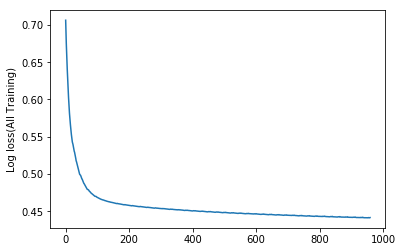

In [18]:
import matplotlib.pyplot as plt
plt.plot(log_loss_plot)
plt.ylabel("Log loss(All Training)")
plt.show()
